In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac

from multiprocessing import Pool

In [3]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [4]:
sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

In [5]:
%config Completer.use_jedi = False

# Load as module

In [6]:
from TracerFit import mwfit, int_idx

In [7]:
run_id=12
size = 100000
file = "sample_1m"

model_full = mwfit(sf_bool=False, perr_bool=False)
model_full.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_full_{run_id:03d}.h')

model_sf = mwfit(sf_bool=False, perr_bool=False)
model_sf.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sfast_{run_id:03d}.h')

model_sf_perr = mwfit(sf_bool=False, perr_bool=False)
model_sf_perr.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perr_{run_id:03d}.h')

model_sf_perrhot = mwfit(sf_bool=False, perr_bool=False)
model_sf_perrhot.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perrHOT_{run_id:03d}.h')

In [22]:
run_id=9
model_sf_perr = mwfit(sf_bool=False, perr_bool=False)
model_sf_perr.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perr_{run_id:03d}.h')

OSError: Unable to open file (unable to open file: name = '/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sample_1m_200000_sf_perr_009.h', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Load data

In [8]:
# Load Sample
sample = {}; true_pars={};
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample_1m.h'
with h5py.File(filename, 'r') as hf:
    subset = np.intersect1d(hf['sample']['source_id'][...], model_full.sample['source_id'], return_indices=True)[1]
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[int_idx(key)]=hf['true_pars'][key][...]
        else:
            true_pars[int_idx(key)]={}
            for par in hf['true_pars'][key].keys():
                true_pars[int_idx(key)][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[j]['w']*=len(sample['source_id'])
    
# Apply Gaia Selection Function
#sample['gaiasf_subset'] = sf_utils.apply_gaiasf(sample['l'], np.arcsin(sample['sinb']), sample['m'])[0]

In [9]:
model_full._generate_fid_pars()
model_full.sample=sample

model_sf._generate_fid_pars()
model_sf.sample=sample

model_sf_perr._generate_fid_pars()
model_sf_perr.sample=sample

model_sf_perrhot._generate_fid_pars()
model_sf_perrhot.sample=sample

Got Selectionfunction pars
Got Selectionfunction pars
Got Selectionfunction pars
Got Selectionfunction pars


# Plot chains

In [10]:
true_params_f = model_full.transform_params(model_full.get_true_params(true_pars))

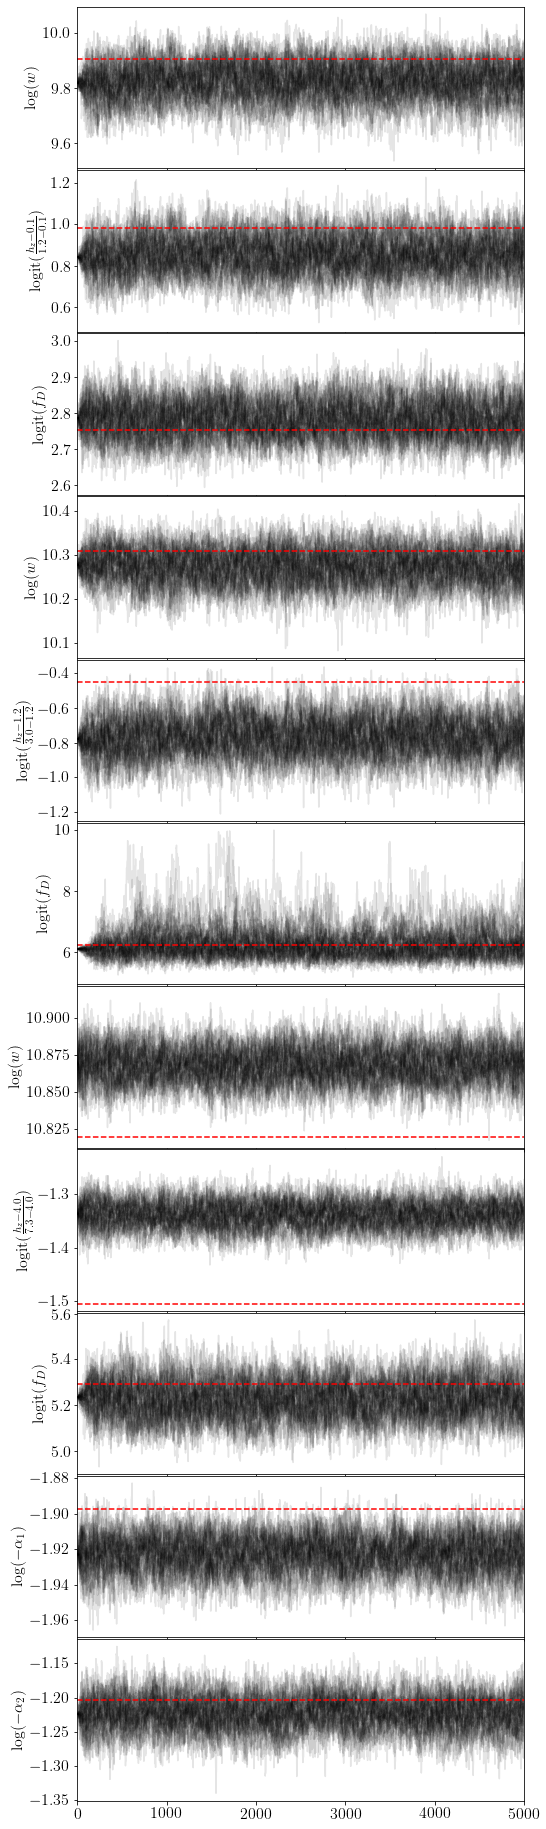

In [11]:
chains = model_full.mcmc_results['chain']['full_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_full.get_labels()
for key in range(chains.shape[2]):
    plt.sca(axes[key])
    for i_walk in range(chains.shape[0]):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
    
    plt.plot([0,nstep],[true_params_f[key],true_params_f[key]], '--r')
        
plt.xlim(0,chains.shape[1])
plt.subplots_adjust(hspace=0.01)

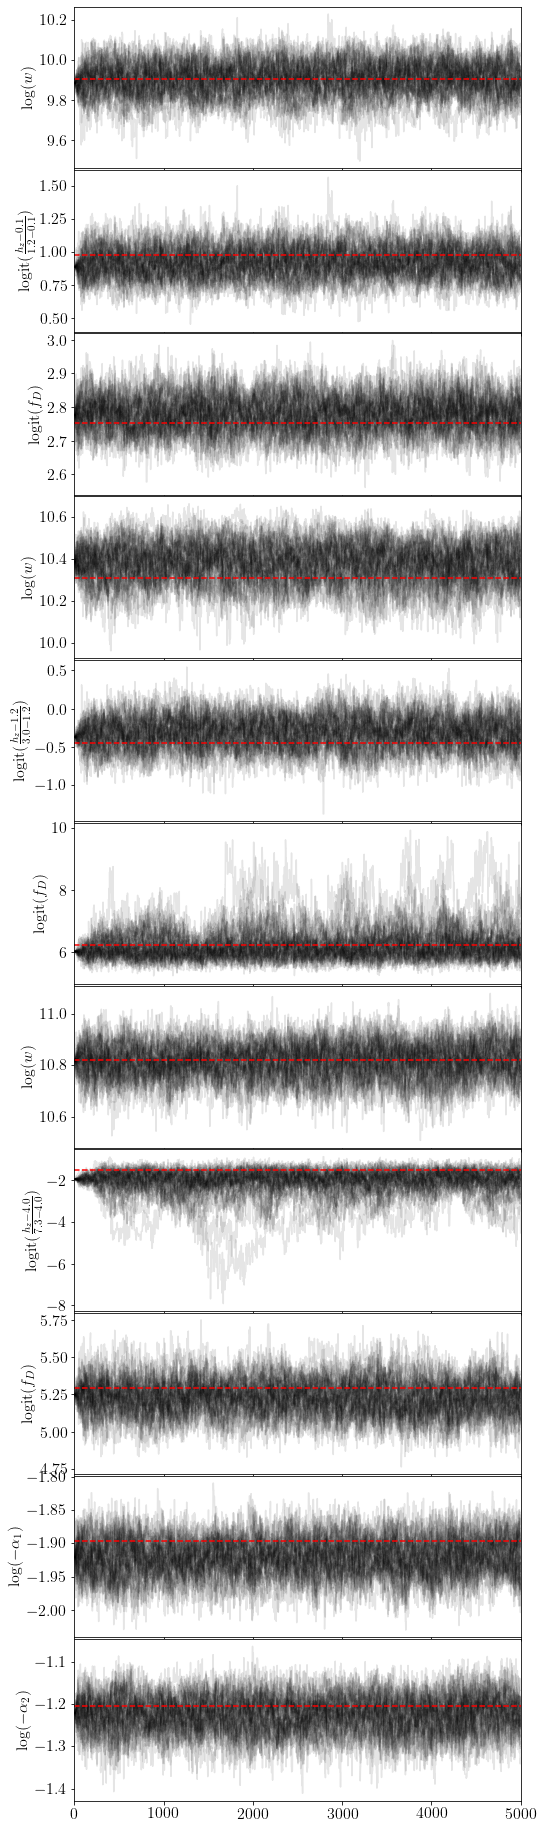

In [12]:
chains = model_sf.mcmc_results['chain']['sf_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_sf.get_labels()
for key in range(chains.shape[2]):
    plt.sca(axes[key])
    for i_walk in range(chains.shape[0]):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
    
    plt.plot([0,nstep],[true_params_f[key],true_params_f[key]], '--r')
        
plt.xlim(0,chains.shape[1])
plt.subplots_adjust(hspace=0.01)

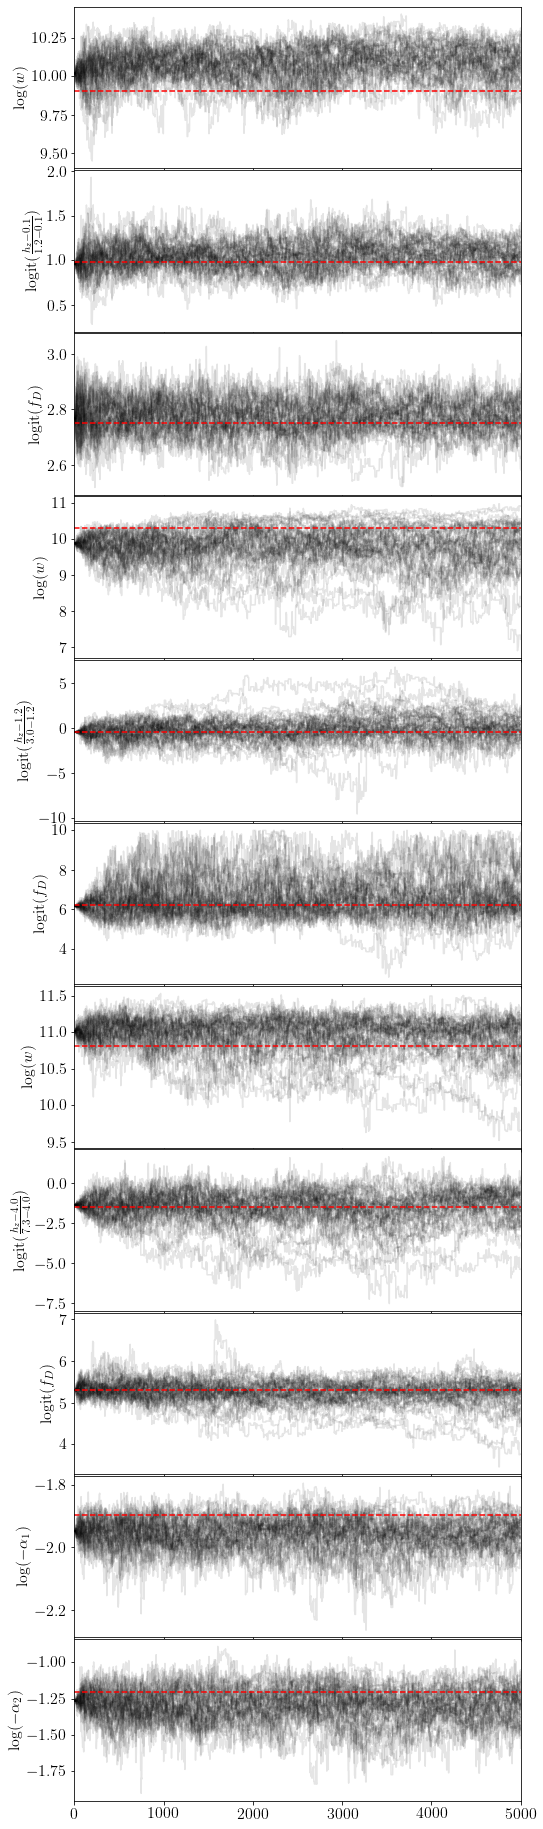

In [13]:
chains = model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_sf_perr.get_labels()
for key in range(ndim):
    plt.sca(axes[key])
    for i_walk in range(nwalk):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
    
    plt.plot([0,nstep],[true_params_f[key],true_params_f[key]], '--r')
    
    
        
plt.xlim(0,nstep)
plt.subplots_adjust(hspace=0.01)

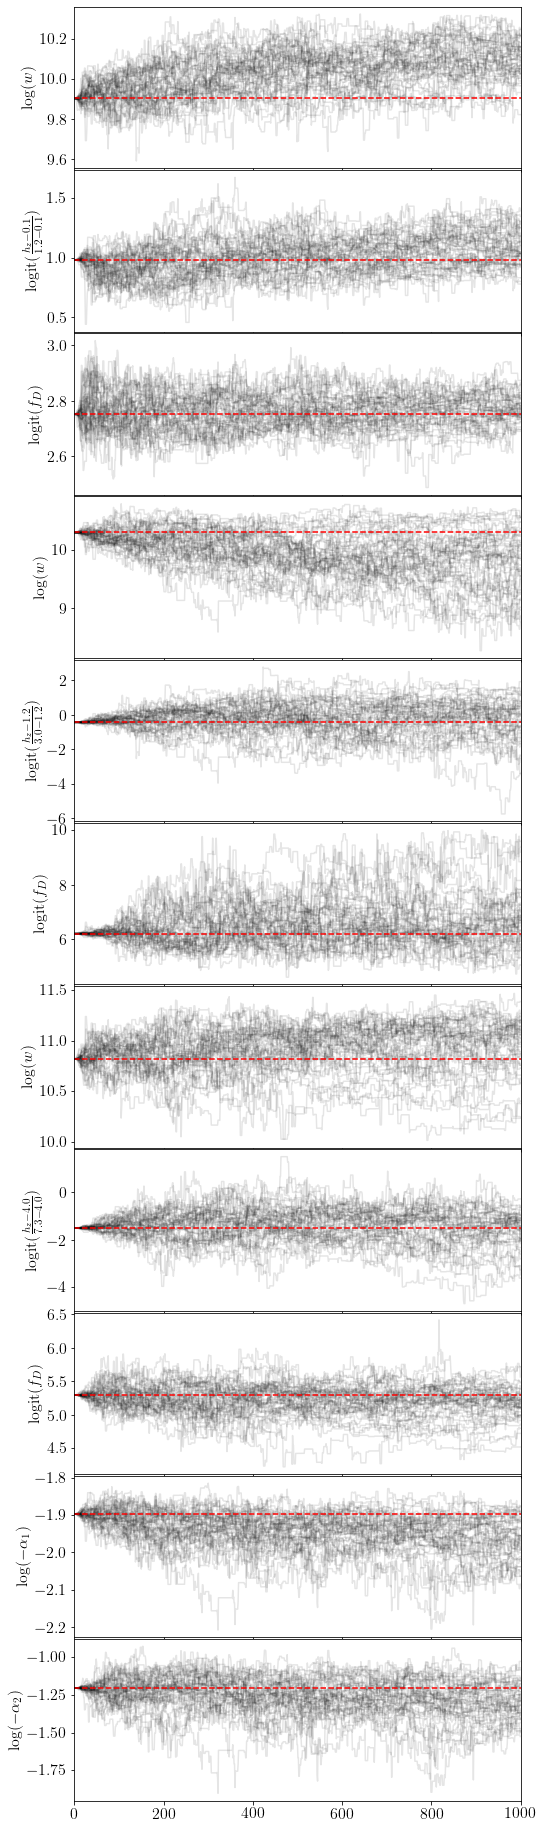

In [14]:
chains = model_sf_perrhot.mcmc_results['chain']['sf_perr_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_sf_perr.get_labels()
for key in range(ndim):
    plt.sca(axes[key])
    for i_walk in range(nwalk):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
    
    plt.plot([0,nstep],[true_params_f[key],true_params_f[key]], '--r')
    
    
        
plt.xlim(0,nstep)
plt.subplots_adjust(hspace=0.01)

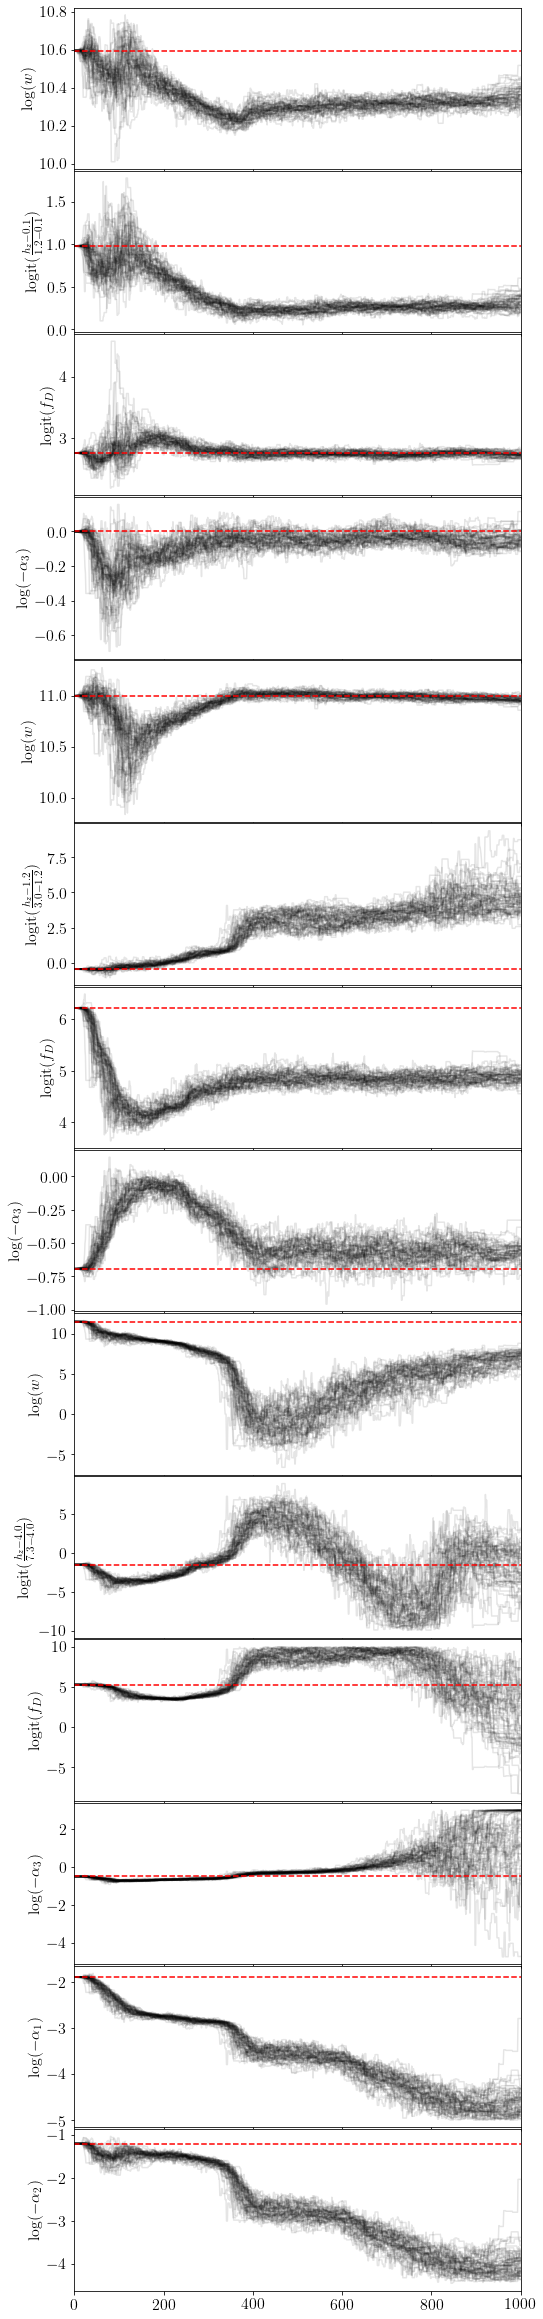

In [14]:
chains = model_sf_perrhot.mcmc_results['chain']['sf_perr_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_sf_perr.get_labels()
for key in range(ndim):
    plt.sca(axes[key])
    for i_walk in range(nwalk):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
    
    plt.plot([0,nstep],[true_params_f[key],true_params_f[key]], '--r')
    
    
        
plt.xlim(0,nstep)
plt.subplots_adjust(hspace=0.01)

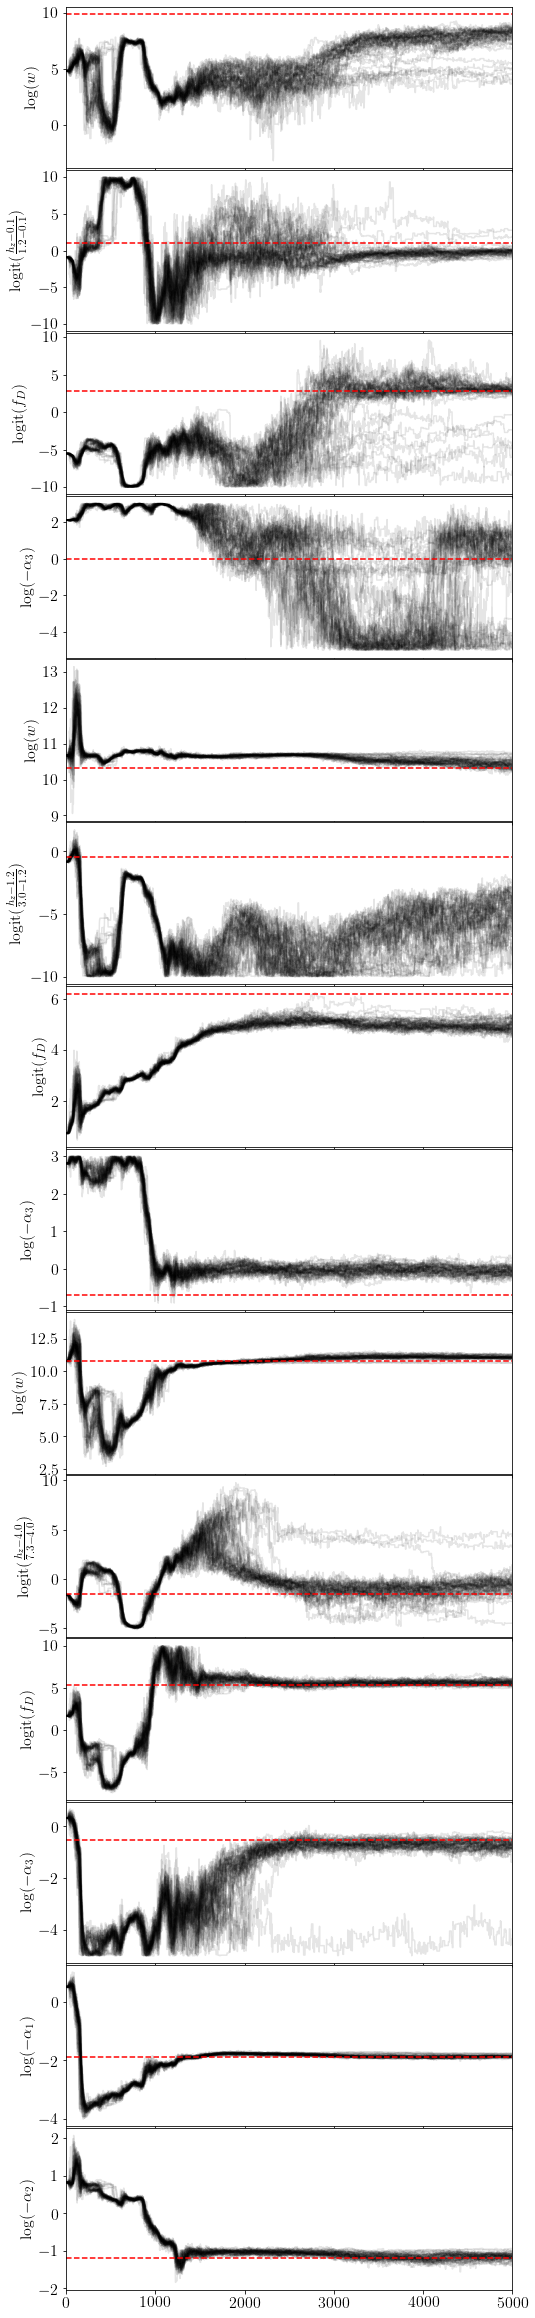

In [30]:
chains = model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_sf_perr.get_labels()
for key in range(ndim):
    plt.sca(axes[key])
    for i_walk in range(nwalk):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
    
    plt.plot([0,nstep],[true_params_f[key],true_params_f[key]], '--r')
    
    
        
plt.xlim(0,nstep)
plt.subplots_adjust(hspace=0.01)

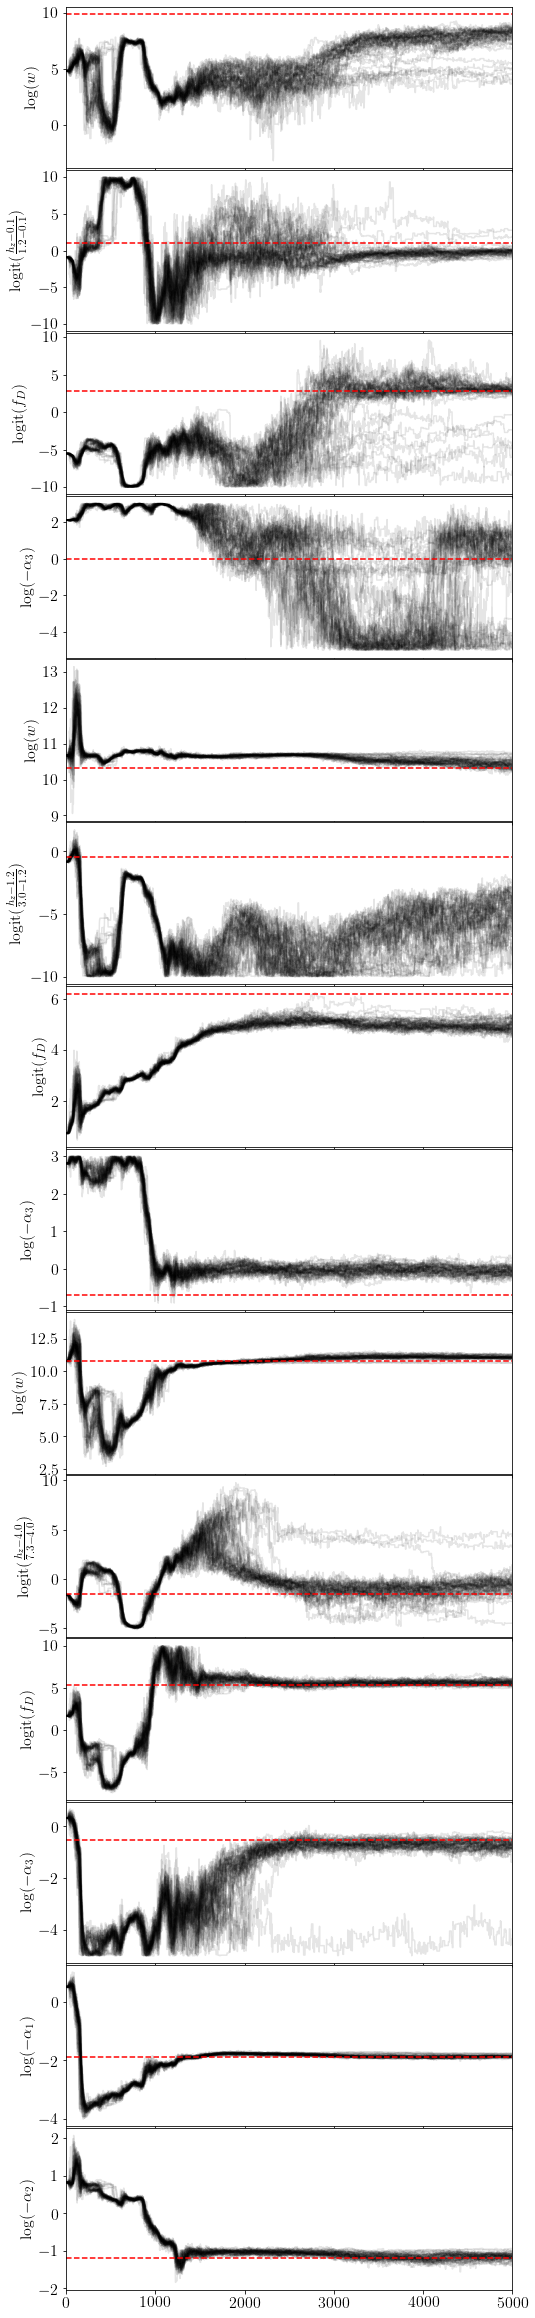

In [16]:
chains = model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_sf_perr.get_labels()
for key in range(ndim):
    plt.sca(axes[key])
    for i_walk in range(nwalk):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
    
    plt.plot([0,nstep],[true_params_f[key],true_params_f[key]], '--r')
    
    
        
plt.xlim(0,nstep)
plt.subplots_adjust(hspace=0.01)

In [21]:
model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'][:,-1,:]

array([[ 8.60871679e+00, -4.01249851e-02,  3.00044856e+00,
        -9.18456503e-03,  1.04813927e+01, -2.29051457e+00,
         4.77233789e+00,  2.87317036e-02,  1.10715754e+01,
        -1.13847186e+00,  6.07275432e+00, -1.06870793e+00,
        -1.90294616e+00, -1.12569196e+00],
       [ 4.31198373e+00,  3.76850179e-01, -4.61651630e+00,
        -4.68948330e-01,  1.06726021e+01, -6.40242392e+00,
         5.25633709e+00, -1.76660981e-01,  1.10156097e+01,
        -9.21027296e-01,  5.54741048e+00, -7.01138255e-01,
        -1.78729582e+00, -1.01225700e+00],
       [ 8.58417053e+00,  6.57596725e-02,  3.25955044e+00,
         1.33112469e+00,  1.03461477e+01, -4.76231898e+00,
         4.62895868e+00, -8.68709467e-02,  1.11003699e+01,
        -6.08149474e-01,  5.92696707e+00, -1.16056350e+00,
        -1.88391095e+00, -1.20354048e+00],
       [ 4.06034343e+00,  2.75703023e+00, -2.36351984e+00,
        -3.28621562e+00,  1.07224684e+01, -7.05434656e+00,
         5.23654783e+00, -1.09347990e-01,  1.

In [24]:
model_sf_perr.mcmc_results['lnprob']['sf_perr_mcmc'][:,-1]

array([160743.50278673, 160702.37154557, 160740.42675633, 160706.24933081,
       160743.28468328, 160707.70168245, 160709.37783804, 160743.80204522,
       160748.46985531, 160728.53214723, 160731.11814596, 160745.20985984,
       160740.5152625 , 160740.49625507, 160739.19188659, 160740.55003551,
       160742.65110813, 160741.34139308, 160731.57437707, 160744.98067742,
       160743.94582946, 160680.90478539, 160743.45530119, 160729.05923789,
       160710.50731853, 160740.96066675, 160743.21628529, 160736.62225977,
       160735.66964242, 160739.36493735, 160743.5685607 , 160739.06319223,
       160744.49570958, 160733.34836348, 160743.45054065, 160729.50723986,
       160743.42003987, 160745.30197002, 160743.33887569, 160746.38649951,
       160739.27022673, 160743.83193009, 160727.22778131, 160739.4327089 ,
       160746.15214222, 160732.70796541, 160739.52421117, 160684.82205521,
       160743.49537576, 160739.55507932, 160732.38854904, 160744.47274024,
       160745.02280995, 1

In [26]:
model_sf_perr.mcmc_results['lnprob']['sf_perr_mcmc'][:,-1][model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'][:,-1,3]<-2]

array([160706.24933081, 160707.70168245, 160731.11814596, 160731.57437707,
       160729.05923789, 160733.34836348, 160729.50723986, 160727.22778131,
       160732.70796541, 160727.00906741])

In [25]:
model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'][:,-1,:][model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'][:,-1,3]<-2]

array([[ 4.06034343e+00,  2.75703023e+00, -2.36351984e+00,
        -3.28621562e+00,  1.07224684e+01, -7.05434656e+00,
         5.23654783e+00, -1.09347990e-01,  1.11121120e+01,
        -1.98915558e+00,  4.99478082e+00, -2.70783551e-01,
        -1.80659449e+00, -1.06344186e+00],
       [ 5.05484690e+00,  7.89817040e-02, -3.35902553e-01,
        -4.16404379e+00,  1.07552807e+01, -4.16921379e+00,
         5.13878935e+00,  4.01090012e-02,  1.13001254e+01,
        -4.48000861e+00,  5.37843060e+00, -5.42330453e-01,
        -1.81877559e+00, -1.09878368e+00],
       [ 8.31039090e+00,  1.88777161e-02,  3.65830686e+00,
        -4.04247193e+00,  1.04595936e+01, -5.56606438e+00,
         4.89718318e+00, -3.63251697e-02,  1.13069784e+01,
        -2.28003631e+00,  5.47337523e+00, -5.77003586e-01,
        -1.94882642e+00, -1.28024556e+00],
       [ 7.22120190e+00, -9.49765185e-01,  2.18028797e+00,
        -4.55242046e+00,  1.05547128e+01, -4.56618081e+00,
         5.01362548e+00, -1.97719428e-01,  1.

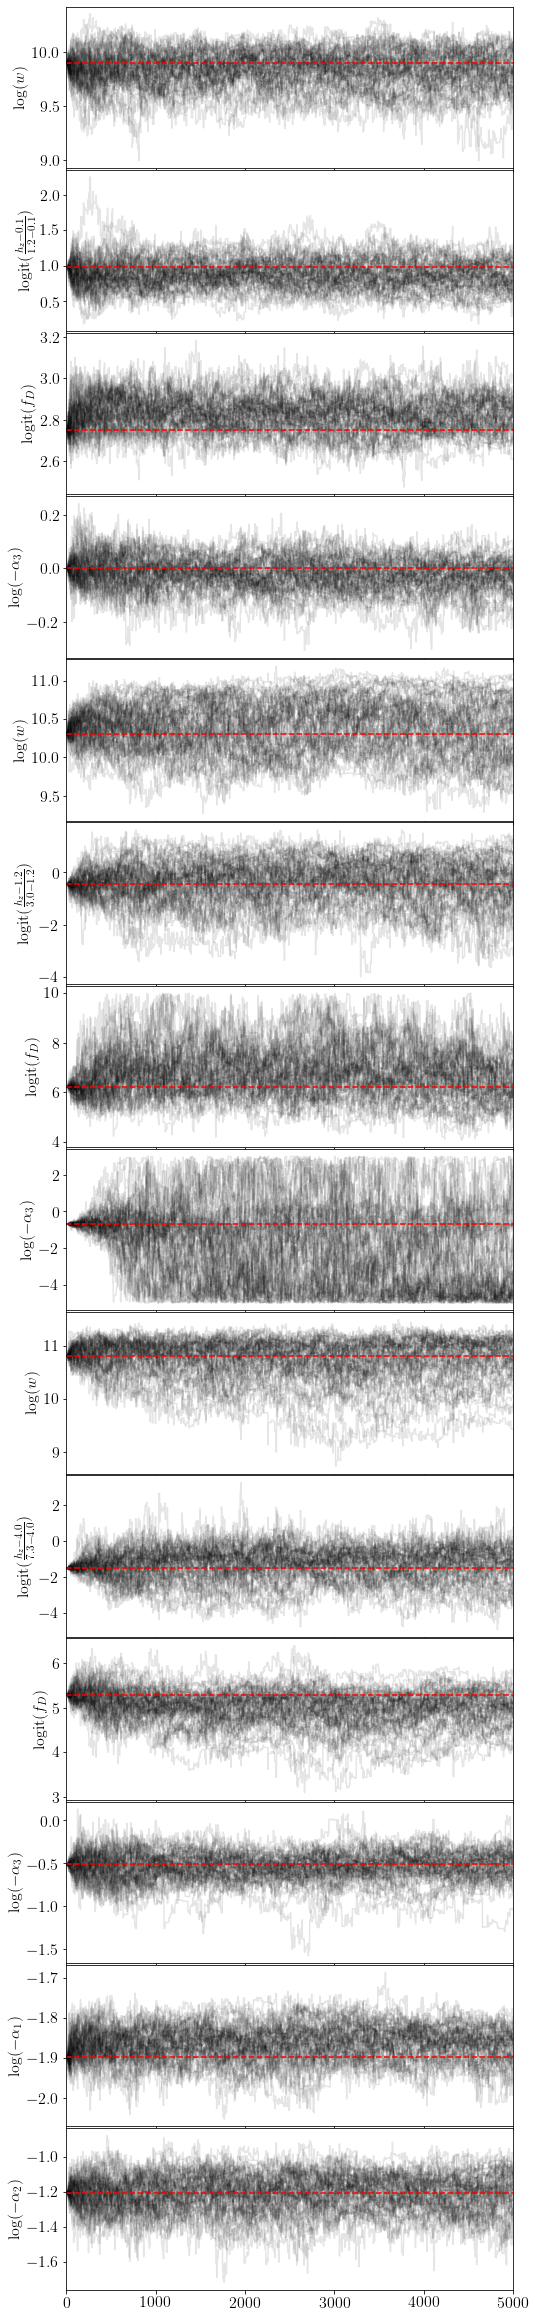

In [33]:
chains = model_sf_perrhot.mcmc_results['chain']['sf_perr_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_sf_perr.get_labels()
for key in range(ndim):
    plt.sca(axes[key])
    for i_walk in range(nwalk):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
    
    plt.plot([0,nstep],[true_params_f[key],true_params_f[key]], '--r')
    
    
        
plt.xlim(0,nstep)
plt.subplots_adjust(hspace=0.01)

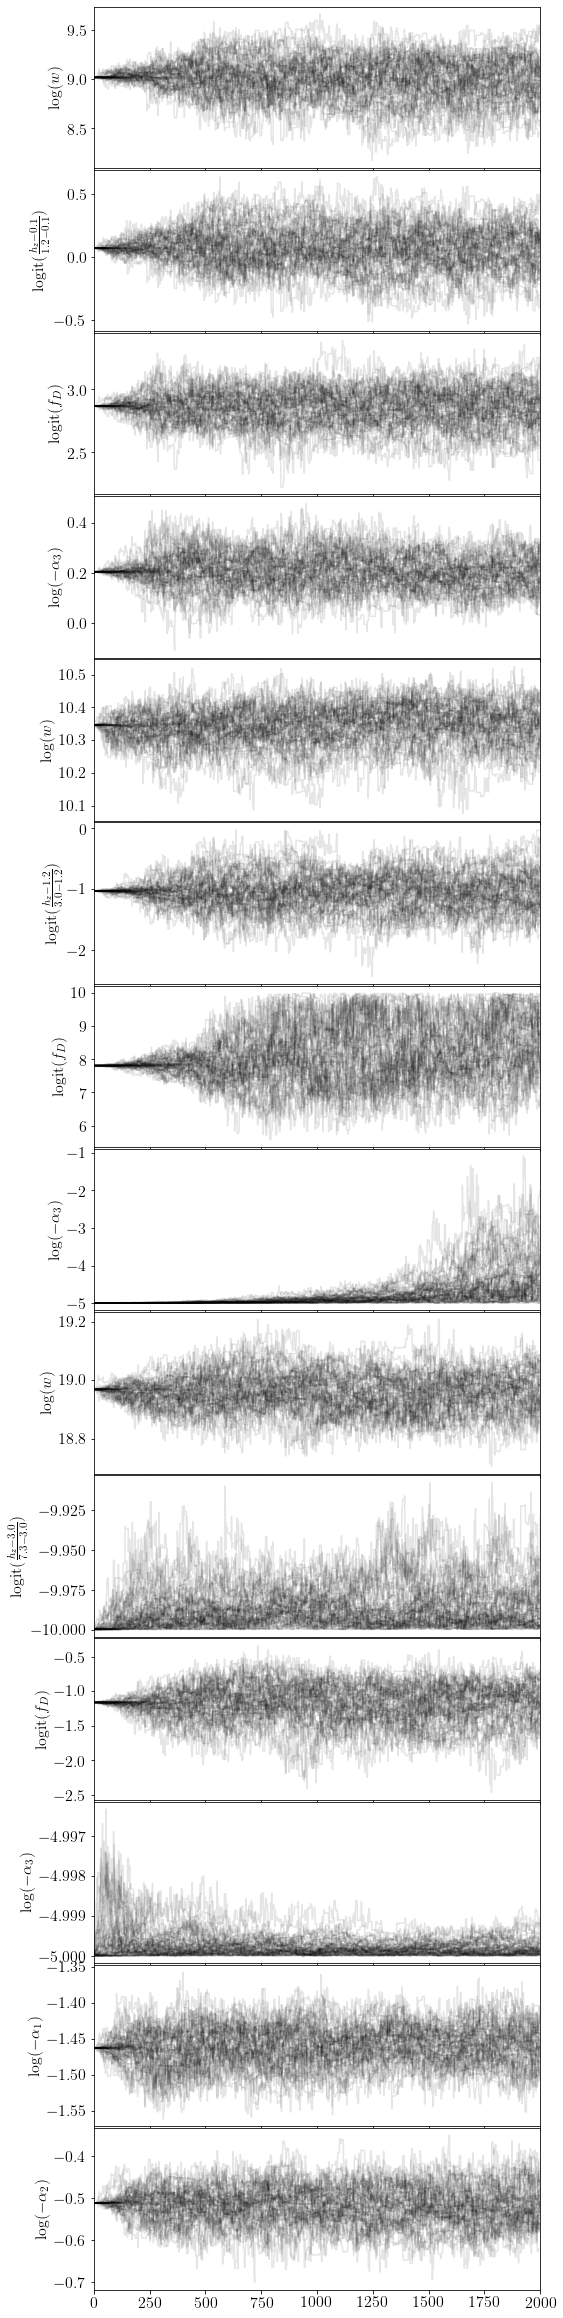

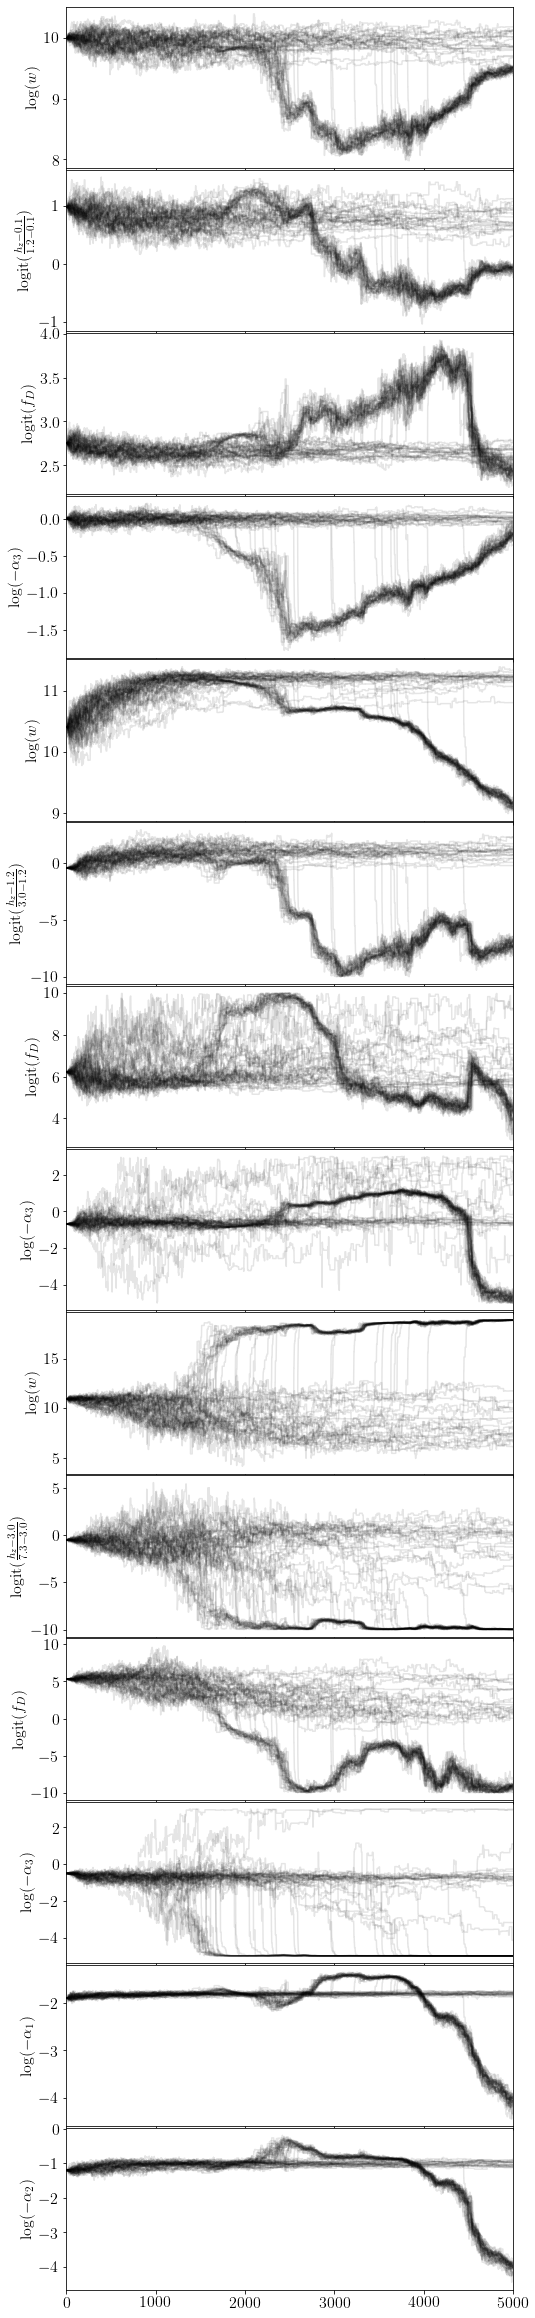

In [17]:
chains = model_sf_perrhot.mcmc_results['chain']['sf_perr_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_sf_perr.get_labels()
for key in range(ndim):
    plt.sca(axes[key])
    for i_walk in range(nwalk):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
        
plt.xlim(0,nstep)
plt.subplots_adjust(hspace=0.01)